In [61]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import  preprocess_input

In [89]:
src_path_train = "./Data/train/"
src_path_valid = "./Data/valid/"
src_path_test = "./Data/test/"

scale=1 / 255.0
rotation=20
zoom=0.05
width_shift=0.05
height_shift=0.05
shear=0.05

train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,
        rotation_range=rotation,
        # zoom_range=zoom,
        width_shift_range=width_shift,
        height_shift_range=width_shift,
        shear_range=shear,
        horizontal_flip=True)

valid_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,    
        dtype='float32',
        rescale=scale,) 

test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        dtype='float32',
        rescale=scale,)

In [90]:
BATCH_SIZE = 32
train_generator = train_datagen.flow_from_directory(
    directory=src_path_train,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    directory=src_path_valid,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    directory=src_path_test,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=1,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [81]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout

In [91]:
NUM_CLASSES = 4

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
HIDDEN_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 1

BATCH_SIZE_TESTING = 1

STEPS_PER_EPOCH_TRAINING = 20
STEPS_PER_EPOCH_VALIDATION = 1

In [92]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [93]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 batch_normalization_11 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense_13 (Dense)            (None, 4)                 8196      
                                                                 
Total params: 23604100 (90.04 MB)
Trainable params: 12292 (48.02 KB)
Non-trainable params: 23591808 (90.00 MB)
_________________________________________________________________


In [94]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [95]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

# cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = './models/best.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [96]:
fit_history = model.fit(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data=valid_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
)

Epoch 1/50
20/20 [==============================] - 8s 279ms/step - loss: 1.0653 - accuracy: 0.5188 - val_loss: 1.3044 - val_accuracy: 0.4062
Epoch 2/50
20/20 [==============================] - 5s 252ms/step - loss: 0.8907 - accuracy: 0.5987 - val_loss: 1.2274 - val_accuracy: 0.5625
Epoch 3/50
20/20 [==============================] - 5s 246ms/step - loss: 0.8353 - accuracy: 0.5987 - val_loss: 1.4834 - val_accuracy: 0.4688
Epoch 4/50
20/20 [==============================] - 5s 246ms/step - loss: 0.8040 - accuracy: 0.6607 - val_loss: 2.3856 - val_accuracy: 0.2500
Epoch 5/50
20/20 [==============================] - 5s 247ms/step - loss: 0.7599 - accuracy: 0.6558 - val_loss: 1.6167 - val_accuracy: 0.3438
Epoch 6/50
20/20 [==============================] - 5s 256ms/step - loss: 0.7451 - accuracy: 0.6607 - val_loss: 1.2246 - val_accuracy: 0.4375
Epoch 7/50
20/20 [==============================] - 5s 253ms/step - loss: 0.7540 - accuracy: 0.6542 - val_loss: 1.1585 - val_accuracy: 0.4688
Epoch 

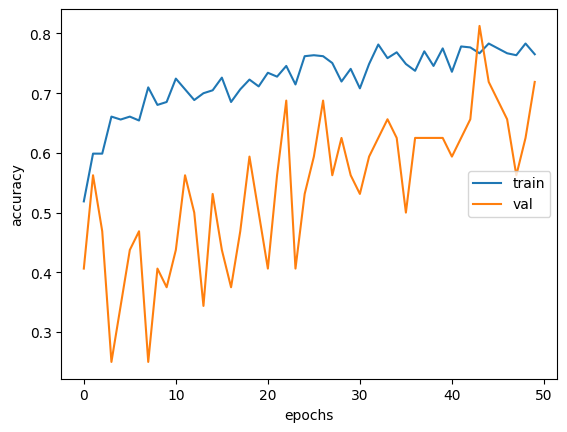

In [99]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [100]:
model.load_weights(filepath='./models/best.hdf5')
model.evaluate(test_generator)

315/315 [==============================] - 5s 17ms/step - loss: 1.1798 - accuracy: 0.5238


[1.1798343658447266, 0.523809552192688]